In [0]:
"""
-----------------------------
| COVID-19 Spread Predictor |     
-----------------------------
        
This program generates a simulation of disease propagation in Canada based on the current 
COVID-19 outbreak.

The program will predict
  1) The course of the disease in Canada if we stay with the current social distancing
  measures
  2) The course of the disease in Canada if we go back to the same habits we had before 
  social distancing

ASSUMPTIONS: The parameters alpha, beta, gamma, mu, ks, ke, ki 
are time dependent 
"""

'\n-----------------------------\n| COVID-19 Spread Predictor |     \n-----------------------------\nAuthor: Tristan Cambell, Travis Innes, Mitchell Karppa, Gurjap Grewal\n        \nThis program generates a simulation of disease propagation in Canada based on the current \nCOVID-19 outbreak.\n\nThe program will predict\n  1) The course of the disease in Canada if we stay with the current social distancing\n  measures\n  2) The course of the disease in Canada if we go back to the same habits we had before \n  social distancing\n\nASSUMPTIONS: The parameters alpha, beta, gamma, mu, ks, ke, ki \nare time dependent \n'

In [0]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from IPython.display import Image
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
"""
We can represent Canada and its provinces as a matrix. Each province can be thought of as a node.
Nodes are linked if there is a direct connection between them (land or air). We now define the 
matrix is two nodes are linked by large amount of air/land trafic or not.

First, let us define the nodes of Canada as [AB, BC, MB, NB, NL, NT, NS, NU, ON, PE, QC, SK, YT]
"""

'\nWe can represent Canada and its provinces as a matrix. Each province can be thought of as a node.\nNodes are linked if there is a direct connection between them (land or air). We now define the \nmatrix is two nodes are linked by large amount of air/land trafic or not.\n\nFirst, let us define the nodes of Canada as [AB, BC, MB, NB, NL, NT, NS, NU, ON, PE, QC, SK, YT]\n'

In [0]:
#1 if the areas are connected, 0 if they are not
#P = {'AB', 'BC',  'MB', ' NB',  'NL',  'NT',  'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT' }
L =  torch.tensor([
     [ 6,     -1,     -1,      0,      0,      0,      0,      0,     -1,      0,     -1,     -1,     -1],
     [-1,      6,     -1,      0,      0,     -1,      0,      0,     -1,      0,     -1,     -1,      0],
     [-1,     -1,      7,      0,      0,     -1,      0,     -1,     -1,      0,     -1,     -1,      0],
     [ 0,      0,      0,      4,     -1,      0,      0,      0,     -1,     -1,     -1,      0,      0],
     [ 0,      0,      0,     -1,      5,      0,     -1,      0,     -1,     -1,     -1,      0,      0],
     [ 0,     -1,     -1,      0,      0,      7,      0,     -1,     -1,      0,     -1,     -1,     -1],
     [ 0,      0,      0,      0,     -1,      0,      4,      0,     -1,     -1,     -1,      0,      0],
     [ 0,      0,     -1,      0,      0,     -1,      0,      6,     -1,      0,     -1,     -1,     -1],
     [-1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     12,     -1,     -1,     -1,     -1],
     [ 0,      0,      0,     -1,     -1,      0,     -1,      0,     -1,      5,     -1,      0,      0],
     [-1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     12,     -1,     -1],
     [-1,     -1,     -1,      0,      0,     -1,      0,     -1,     -1,      0,     -1,      7,      0],
     [-1,      0,      0,      0,      0,     -1,      0,     -1,     -1,      0,     -1,      0,      5]]);


In [0]:
"""
In the attempt to understand how we can prevent the spread of COVID19, we now review
a simple model and see how we can control the spead of the virus.

In our model, we consider 4 groups of population
1. S - Susceptable, healty people that have no virus 
2. E - Exposed, people who contracted the virus but are not sick
3. I - Infected, people who were exposed and became sick
4. R - Recovered, those who recovered (or died)

A typical flow is S --> E --> I --> R
We will use parameters α, β, γ, μ, κS, κE, κI to symbolize our random walk.

α is the parameter that influences the rate at which people exposed to the virus become infected.
β is the parameter that influences the rate at which people exposed to the virus pass it on to the susceptable population.
γ is the parameter that influences the rate at which people infected with the virus pass it on to the susceptable population.
μ is the parameter that influences the rate at which people infected with the virus either recover or die.

The parameters  β  and  γ  are determined by the mixing of the populations. Below
you can see it is easier to control  γ  since we can take better isolation for sick 
people but the parameter  β  is harder to control. For close interactions  β  is 
large and when interactions are limited it is much smaller. κS, κE, κI are parameters 
based on spread through travel.

These equations are the equations of SEI
The limit as δt→0.
  dS/dt = -κ − βES −γIS 
  dE/dt = -κ + βES + γIS −αE
  dI/dt = -κ + αE − μI

"""

In [0]:
def SEImodel(theta,S,E,I):

    alpha = theta[0]
    beta = theta[1]
    gamma = theta[2]
    mu = theta[3]
    ks = theta[4]
    ke = theta[5]
    ki = theta[6]

    dSdt = torch.zeros(13)
    dEdt = torch.zeros(13)
    dIdt = torch.zeros(13)
    
    for j in range(13):
        
        dSdt[j] = -sum((ks)*(L[:,j])*(S)) - (beta)*(E[j])*(S[j]) - (gamma)*(I[j])*(S[j]) 
        dEdt[j] = -sum((ke)*(L[:,j])*(E)) + (beta)*(E[j])*(S[j]) + (gamma)*(I[j])*(S[j]) - (alpha)*(E[j])
        dIdt[j] = -sum((ki)*(L[:,j])*(I)) + (alpha)*(E[j]) - (mu)*(I[j]);
    
    return dSdt, dEdt, dIdt

In [0]:
"""
We now integrate the equation in time using the forward Euler Method
"""

In [0]:
def integrateSEI(theta,theta1,S0,E0,I0,dt,nt):
    
    S = torch.zeros(13)
    E = torch.zeros(13)
    I = torch.zeros(13)
    dSdt = torch.zeros(13)
    dEdt = torch.zeros(13)
    dIdt = torch.zeros(13)
    
    # vectors to save the results over time
    Sout = torch.zeros(nt+1,13); Sout[0] = S0
    Eout = torch.zeros(nt+1,13); Eout[0] = E0
    Iout = torch.zeros(nt+1,13); Iout[0] = I0
    
    S = S0; E = E0; I = I0
    
 
    for i in range(nt):
        
        if i < 200:
            dSdt, dEdt, dIdt = SEImodel(theta,S,E,I)
            
        elif ( i > 200 and i < 340):
            dSdt, dEdt, dIdt = SEImodel(theta1,S,E,I)
            
        elif i > 340:
            dSdt, dEdt, dIdt = SEImodel(theta,S,E,I)
            
            
        S = S + dt*dSdt
        E = E + dt*dEdt
        I = I + dt*dIdt
        
        Sout[i+1] = S; Eout[i+1] = E; Iout[i+1] = I;
        
    return Sout, Eout, Iout

In [0]:
"""
Below is one of two scenarios:

I) SEI + LOSS + GRADIENT DECENT
Initially we define the SEI models, but we also define a loss function. From here do gradient descent.
This scans through the various combinations of parameter values to find one gives us the lowest loss value. This in 
turn would give us our optimal parameter values. Although, this solution will yeild us the correct results, 
the problem comes from the number of loops we must run through to find the parameters. Upon testing, we let 
the program run for a half-hour without success.

II) SEI + GUESS AND CHECK: 
We have a scenario in which we guess and checked the parameters to fit the current outbreak of COVID 
from the period of April 21st. The parameters are estimated based on assumtions of the activity of two 
different schemes. One reflects the outbreak of COVID with protective measures taken and the other without.
This method is used without the use of the loss coefficent and gradient decent. This method also proves to 
be less accurate as it scales as parameters may not perfectly reflect the situation.
"""

In [0]:
"""
 SCENARIO 1
 -----------

We can now define a loss function that we will use in a series of loops to find the smallest possible 
parameter values.

DO NOT RUN SCENARIO 1 CODE CELLS WHEN TRYING TO GET GRAPH AND VALUE OUTPUTS AT THE END OF CODE.  WE HAVE INCLUDED 
THIS CODE TO SHOW OUR THOUGHT PROCESS, HOWEVER THIS CAUSES AN ERROR DUE TO REDUNDANCIES IN OUR FULL CODE

"""

In [0]:
#population with infected on april 5th
Interpopinf = torch.tensor([0.001250, 0.0001203, 0.000187, 0.000101, 0.000217, 0.000004, 0.000262, 0.0, 0.004038, 0.000022, 0.007944, 0.000249, 0.000006])
Iobs = Spopinf/Pop

def loss (alpha, beta, gamma, mu, ks, ke, ki, Iobs, S0, E0, I0, dt):
    
    #will give us non quarantine numbers#
    nt = 200
    
    Scomp, Ecomp, Icomp = integrateSEI1(alpha, beta, gamma, mu, ks, ke, ki,S0,E0,I0,dt,nt)
    phi = sum((Icomp[200,:] - Iobs)**2)
          
    return phi


In [0]:
N = 50
domain = (0,1)
x = 10000000

for i, alpha in enumerate(torch.linspace(domain[0], domain[1], N)):
    for j, beta in enumerate(torch.linspace(domain[0], domain[1], N)):
        for k, gamma in enumerate(torch.linspace(domain[0], domain[1], N)):
            for l, mu in enumerate(torch.linspace(domain[0], domain[1], N)):
                for m, ks in enumerate(torch.linspace(domain[0], domain[1], N)):
                    for n, ke in enumerate(torch.linspace(domain[0], domain[1], N)):
                        for b, ki in enumerate(torch.linspace(domain[0], domain[1], N)):
                            
                            phi = loss(alpha, beta, gamma, mu, ks, ke, ki, Iobs, S0, E0, I0, dt)
                            
                            if x < phi:
                                phi = 0
                                
                            elif x > phi:
                                x = phi
                                phi = 0
                                parameters = torch.tensor([alpha, beta, gamma, mu, ks, ke, ki])

In [0]:
"""
 SCENARIO 2
 -----------
In this alternative version we use a guess and check method, so parameters are correct in this situatuion,
although do not scale perfectly

"""

In [0]:
#time simulation runs for#
nt = 2000
dt = 0.1

#Populations of the provinces(mill)#
Pop = torch.tensor([4.371, 5.071, 1.369, 0.776, 0.522, 0.045, 0.971, 0.0038, 14.57, 0.157, 8.485, 1.174, 0.036])

#Population of infected poeple used for optimization#
#initial will be the from stats on March 15th 2020#
Ipopinf = torch.tensor([0.000039, 0.000079, 0.000004, 0.000001, 0.0, 0.0, 0.0, 0.0, 0.000103, 0.000001, 0.000024, 0.0, 0.0])
#optimize to april 5th for no precautions taken#
#take sick from april 5th to current for precautions taken#

#initial percentage of population with real initial conditions
S0 = (Pop - Ipopinf)/Pop
E0 = torch.zeros(13)
I0 = (Ipopinf)/Pop


#parameters for without protective measures taken#
alpha = 0.2
beta = 0.4
gamma = 0.15
mu = 0.075
ks = 0.019
ke = 0.019
ki = 0.019
theta = torch.tensor([alpha, beta, gamma, mu, ks, ke, ki])

#parameters with protective measures taken#
alpha1 = 0.2
beta1 = 0.025
gamma1 = 0.01
mu1 = 0.075
ks1 = 0.001
ke1 = 0.001
ki1 = 0.0000001
theta1 = torch.tensor([alpha1, beta1, gamma1, mu1, ks1, ke1, ki1])

S, E, I = integrateSEI(theta,theta1, S0, E0, I0, dt, nt)

t = np.arange(nt+1)*dt

In [0]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

def infected(province_number, province):
 
  print(color.BOLD + str(province) + color.END)

  plt.plot(t,S[:,province_number], t, E[:,province_number], t, I[:,province_number])
  Iprcntmax = (max(I[:,province_number]))

  print('max people infected')
  print(max(I[:,province_number]*Pop[province_number]*1000000))

  print('max percent people infected')
  print(max(I[:,province_number]))

  print('people infected April 21st')
  print(I[340,province_number]*Pop[province_number]*1000000)

  print('percent infected April 21st')
  print(I[340,province_number])


In [0]:
"""
Put in seperate code spaces as graphs compound when ran through same.

Run any province or territory to see the individual maximum predicted impact 
for COVID19. 

"""

Alberta
max people infected
tensor(1745886.1250)
max percent people infected
tensor(0.3994)
people infected April 21st
tensor(1439.8645)
percent infected April 21st
tensor(0.0003)


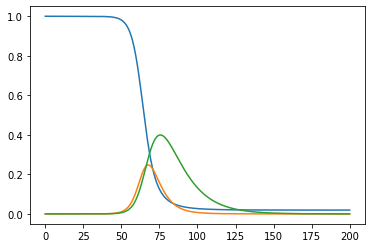

In [0]:
infected(0,"Alberta")

British Columbia
max people infected
tensor(2025454.)
max percent people infected
tensor(0.3994)
people infected April 21st
tensor(1872.3793)
percent infected April 21st
tensor(0.0004)


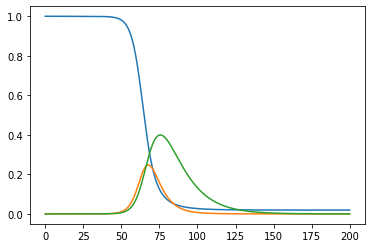

In [0]:
infected(1,"British Columbia")

Manitoba
max people infected
tensor(546818.3125)
max percent people infected
tensor(0.3994)
people infected April 21st
tensor(394.0648)
percent infected April 21st
tensor(0.0003)


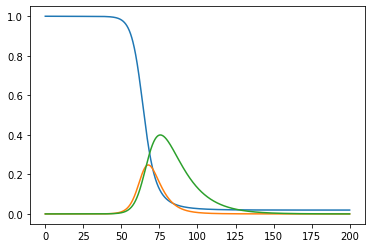

In [0]:
infected(2,"Manitoba")

New Brunswick
max people infected
tensor(309989.6250)
max percent people infected
tensor(0.3995)
people infected April 21st
tensor(163.7847)
percent infected April 21st
tensor(0.0002)


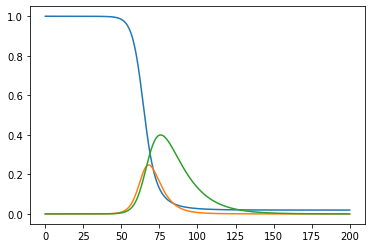

In [0]:
infected(3,"New Brunswick")

New Foundland & Labrador
max people infected
tensor(208524.2344)
max percent people infected
tensor(0.3995)
people infected April 21st
tensor(102.1198)
percent infected April 21st
tensor(0.0002)


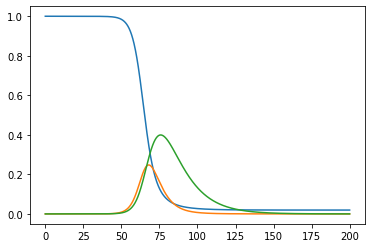

In [0]:
infected(4,"New Foundland & Labrador")

Northwest Territories
max people infected
tensor(17974.6035)
max percent people infected
tensor(0.3994)
people infected April 21st
tensor(11.4274)
percent infected April 21st
tensor(0.0003)


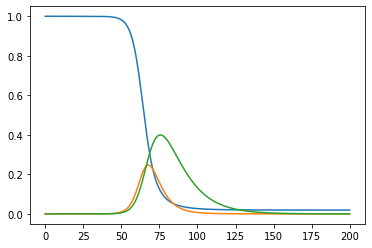

In [0]:
infected(5,"Northwest Territories")

Nova Scotia
max people infected
tensor(387887.0938)
max percent people infected
tensor(0.3995)
people infected April 21st
tensor(184.5403)
percent infected April 21st
tensor(0.0002)


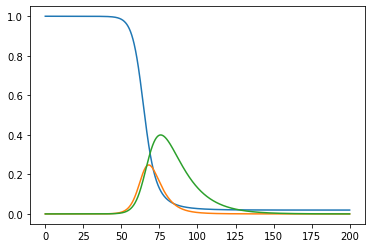

In [0]:
infected(6,"Nova Scotia")

Nunavut
max people infected
tensor(1517.8834)
max percent people infected
tensor(0.3994)
people infected April 21st
tensor(0.8274)
percent infected April 21st
tensor(0.0002)


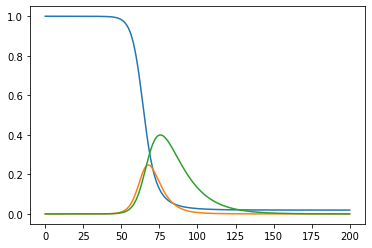

In [0]:
infected(7,"Nunavut")

Nova Scotia
max people infected
tensor(5819711.5000)
max percent people infected
tensor(0.3994)
people infected April 21st
tensor(3737.1775)
percent infected April 21st
tensor(0.0003)


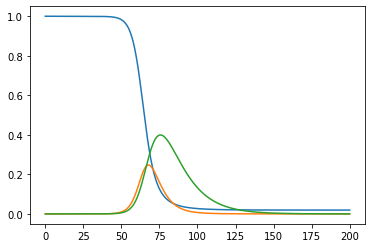

In [0]:
infected(8,"Nova Scotia")

Ontario
max people infected
tensor(62716.7891)
max percent people infected
tensor(0.3995)
people infected April 21st
tensor(38.3573)
percent infected April 21st
tensor(0.0002)


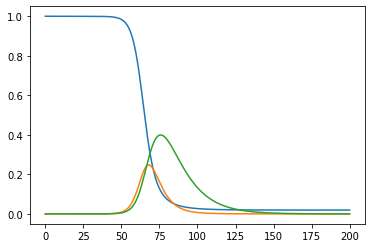

In [0]:
infected(9,"Ontario")

Quebec
max people infected
tensor(3389173.2500)
max percent people infected
tensor(0.3994)
people infected April 21st
tensor(2157.4028)
percent infected April 21st
tensor(0.0003)


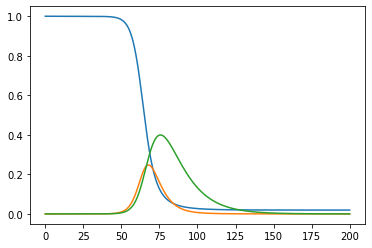

In [0]:
infected(10,"Quebec")

Saskatchewan
max people infected
tensor(468930.0312)
max percent people infected
tensor(0.3994)
people infected April 21st
tensor(325.6803)
percent infected April 21st
tensor(0.0003)


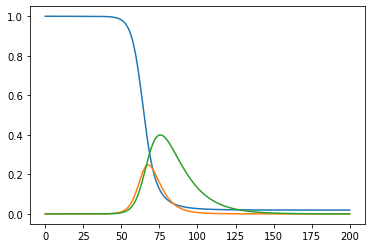

In [0]:
infected(11,"Saskatchewan")

Yukon
max people infected
tensor(14380.0332)
max percent people infected
tensor(0.3994)
people infected April 21st
tensor(8.0008)
percent infected April 21st
tensor(0.0002)


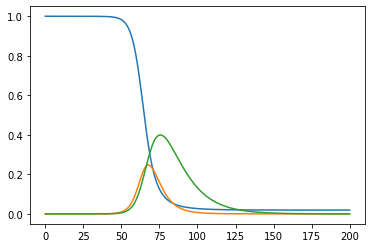

In [0]:
infected(12,"Yukon")